# EEE4114F ML Project Code

The motionsense dataset is divided into three main folders:

- **(A) DeviceMotion_data:** Contains a rich combination of accelerometer, gyroscope, and orientation-related features — 12 features in total.

- **(B) Accelerometer_data:** Includes only the raw accelerometer readings (x, y, z) — 3 features.

- **(C) Gyroscope_data:** Includes only the raw gyroscope readings (x, y, z) — 3 features.


From these, **(A) DeviceMotion_data** provides the most comprehensive set of features, combining both linear and rotational data, as well as derived orientation estimates:

- **Attitude (roll, pitch, yaw)** showing device orientation (e.g., facing up/down)
- **Gravity (x, y, z)** showing static acceleration (orientation wrt gravity)
- **Rotation Rate (x, y, z)** showing angular velocity from gyroscope
- **User Acceleration (x, y, z)** showing motion (dynamic body acceleration)


## Libraries to import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Loading the data
Here are some useful functions from motionsense.ipyb we have copied. It helps to copy the data from (A) DeviceMotion_data as a labeled time series dataset.

In [2]:
def get_ds_infos():
    """
    Read the file includes data subject information.

    EEE4114: Technically we do not need these data, as we are not concerned about identifying the subjects. 
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains information about data subjects' attributes 
    """ 

    dss = pd.read_csv(f'C:/Users/emanu/Documents/GithubRepos/EEE4114F-ML-Project-2025/data/data_subjects_info.csv')
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset. 

    EEE4114F: Choose sensors that you think are useful or would like to include in training. 
    You can choose all of them, or you could opt to try a limited set of input features
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    EEE4114F: This defines what data you would like to include for a given set.  

    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activities.
        trial_codes: list of trial codes corresponding to each activity.
        mode: It can be "raw" (all dimensions of each data type) or "mag" (only magnitude per data type).
        labeled: True if labeled dataset (adds 'act', 'trial', 'sub_id'), False otherwise.

    Returns:
        pd.DataFrame: Time-series sensor data with optional labels.
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list * 3)

    if labeled:
        # +3 for act, trial, sub_id labels
        dataset = np.zeros((0, num_data_cols + 3))
    else:
        dataset = np.zeros((0, num_data_cols))

    ds_list = get_ds_infos()  # Assume this returns dict with "code" key for subject IDs

    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = f'C:/Users/emanu/Documents/GithubRepos/EEE4114F-ML-Project-2025/data/A_DeviceMotion_data/{act}_{trial}/sub_{int(sub_id)}.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        # Calculate magnitude of 3 axes per sensor type
                        vals[:, x_id] = (raw_data[axes] ** 2).sum(axis=1) ** 0.5        
                    else:
                        vals[:, x_id * 3:(x_id + 1) * 3] = raw_data[axes].values
                    vals = vals[:, :num_data_cols]
                if labeled:
                    # Add act, trial, sub_id as labels (same length as vals)
                    lbls = np.array([[act_id, trial, sub_id]] * len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset, vals, axis=0)

    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]  # Use first part of sensor name for magnitude

    if labeled:
        cols += ["act", "trial", "sub_id"]

    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

In [3]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "gravity", "rotationRate", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS # choose all 6 classes
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'gravity', 'rotationRate', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 15)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,trial,sub_id
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,1.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,1.0,1.0


## Windowing and Splitting the Data

Uses more useful definitions from motionsense.ipyb - the windows() function and MotionSense class.

In [4]:
def windows(dataset, window_size=400, stride=200):
    """
    Slice dataset into overlapping windows of fixed length.

    Args:
        dataset (pd.DataFrame): Time-series data with sensor features and 'act' label column.
        window_size (int): Number of samples per window.
        stride (int): Step size between windows.

    Returns:
        pd.DataFrame: A new DataFrame with flattened windows and corresponding labels.
    """

    # Separate the feature values and labels
    features = dataset.drop(columns=['act']).values  # Shape: [n_samples, n_features]
    labels = dataset['act'].values  # Shape: [n_samples]

    # Lists to collect the processed windows and labels
    windowed_data = []
    windowed_labels = []

    # Iterate over the dataset with a sliding window
    for start in range(0, len(dataset) - window_size + 1, stride):
        end = start + window_size

        # Extract a window of features and corresponding labels
        window = features[start:end]           # Shape: [window_size, n_features]
        label_window = labels[start:end]       # Shape: [window_size]

        # Flatten the feature window by transposing to [n_features, window_size], then flatten to 1D
        window_flat = window.T.flatten()       # Final shape: [n_features * window_size]

        # Assign the most frequent label in the window as the representative label
        label = np.bincount(label_window.astype(int)).argmax()

        # Append the flattened window and label to the lists
        windowed_data.append(window_flat)
        windowed_labels.append(label)

    # Convert the list of windows to a DataFrame (each row is one flattened window)
    X = pd.DataFrame(windowed_data)

    # Convert the list of labels to a Series
    Y = pd.Series(windowed_labels, name='act')

    return X, Y

In [5]:
class MotionSense(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = torch.tensor(X.values)
        self.Y = torch.tensor(Y.values)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.X[index]
        y = self.Y[index]

        return x, y

    def __len__(self):
        return len(self.X)

#### Chose to randomly split data 85% for training and 15% for testing, and to do it subject-wise to avoid data leakage across subjects.

#### Knowing that the minimum recording length is 377, we chose a window size of 400.

#### We chose a stride of 200, 50% of the window size.


In [6]:
# Split subjects for train/test
unique_sub_ids = dataset['sub_id'].unique()  # Get list of unique subject IDs
train_subs, test_subs = train_test_split(unique_sub_ids, test_size=0.15, random_state=98765)  
# Randomly split subjects: 85% for training, 15% for testing (subject-wise split ensures no data leakage across subjects)

train_df = dataset[dataset['sub_id'].isin(train_subs)].reset_index(drop=True)  # Extract training data from selected subjects
test_df = dataset[dataset['sub_id'].isin(test_subs)].reset_index(drop=True)    # Extract test data from held-out subjects

# Select only sensor features (exclude meta-info like 'sub_id') and the activity label
feature_cols = [
    'attitude.roll', 'attitude.pitch', 'attitude.yaw',
    'gravity.x', 'gravity.y', 'gravity.z',
    'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 
    'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'
] 
filtered_train_df = train_df[feature_cols + ['act']]  # Retain only sensor features + label for training
filtered_test_df = test_df[feature_cols + ['act']]    # Same for test data

# Apply windowing to create overlapping segments of fixed length from continuous data
X_train, Y_train = windows(filtered_train_df, window_size=400, stride=200)
X_test, Y_test = windows(filtered_test_df, window_size=400, stride=200)
# Result: X_* are DataFrames of flattened windows, Y_* are Series of majority labels per window


## K-Fold Cross-Validation
K-Fold Cross-Validation is a technique to evaluate model performance by splitting the dataset into *k* equal parts (folds).
- The dataset is split into **5 folds**.
- For each of the 5 iterations:
  - **4 folds are used for training**, and
  - **1 fold is used for validation**.
- Each fold serves as the validation set exactly once.
- After all iterations, performance metrics are averaged to give a robust estimate of model generalization.
This method ensures that every data point is used for both training and validation, helping to reduce overfitting and improve reliability.

In [7]:
k_folds = 5  # Define number of folds for cross-validation

# Initialize KFold cross-validator (shuffling ensures different class distributions across folds)
kf = KFold(n_splits=5, shuffle=True, random_state=12345)
all_splits = list(kf.split(X_train))  # Create list of (train_idx, val_idx) splits for each fold


## Define Model Architecture - FCNet

Due to the ease of implementation and interpretability (and since it was included in the motionsense.ipyb), we have decided to explore the FCNet architecture as the model architecture for classifying. 

The main parameters here is the input size (12 features * 400 time steps), the size of the hidden layer, and the total number of activity classes to clasify (which we all know is 6). 

The 4800 features became 50 then became 6 features, and to improve learning stability and generalisation, we also applied batch normalisation, ReLU activation and dropout (rate 0.5).

In [8]:
# Define the improved fully connected neural network for time-series classification
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()

        # First fully connected layer: input -> hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)      # Batch normalization to stabilize learning
        self.dropout1 = nn.Dropout(0.5)             # Dropout to prevent overfitting

        # Second fully connected layer: hidden_size -> hidden_size // 2
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2) # Batch normalization
        self.dropout2 = nn.Dropout(0.5)             # Dropout again for regularization

        # Final layer: hidden_size // 2 -> number of classes
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input from [batch, channels, time] to [batch, features]

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)  # Final output layer (no activation here; loss function will handle it)
        return x

# Parameters — adjusted according to our input window configuration
input_size = 12 * 400     # 12 sensor features per timestep × 400 time steps per window
hidden_size = 50          # Size of hidden layer (can be tuned)
num_classes = 6           # Total number of activity classes to classify

## Model Training and Evaluation

Here we train for 50 epochs. This was enough epochs for convergence whilst not under- or overfitting.

We also use the Adam optimiser (better than standard gradient descent!) at a learning rate of 0.001.

During the training, we track the training and validation losses and accuracies, as well as the best accuracy and the corresponding model for subsequent training.

In [9]:
num_epochs = 50  # Number of epochs to train per fold

# Track the best performing model across all folds
best_val_acc = 0
best_model_state = None

# Lists to store metrics for each fold
fold_train_losses = [[] for _ in range(k_folds)]
fold_val_losses = [[] for _ in range(k_folds)]
fold_train_accuracies = [[] for _ in range(k_folds)]
fold_val_accuracies = [[] for _ in range(k_folds)]

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(all_splits):
    print(f"Fold {fold + 1}")

    # Prepare train and validation splits
    X_tr = X_train.iloc[train_idx].reset_index(drop=True)
    Y_tr = Y_train.iloc[train_idx].reset_index(drop=True)
    X_val = X_train.iloc[val_idx].reset_index(drop=True)
    Y_val = Y_train.iloc[val_idx].reset_index(drop=True)

    # Wrap data into custom dataset class
    train_ds = MotionSense(X_tr, Y_tr)
    val_ds = MotionSense(X_val, Y_val)

    # Create DataLoaders
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, drop_last=True)

    # Initialize model, loss function, and optimizer
    model = FCNet(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train for the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_dl:
            optimizer.zero_grad()                 # Clear previous gradients
            outputs = model(inputs.float())       # Forward pass
            loss = criterion(outputs, labels.long())  # Compute loss
            loss.backward()                       # Backward pass
            optimizer.step()                      # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dl)
        train_acc = 100 * correct / total

        # Store metrics for this epoch
        fold_train_losses[fold].append(train_loss)
        fold_train_accuracies[fold].append(train_acc)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                outputs = model(inputs.float())         # Forward pass
                loss = criterion(outputs, labels)       # Compute validation loss
                val_loss += loss.item() * inputs.size(0)  # Accumulate total loss

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        # Log metrics
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}%")

        fold_val_losses[fold].append(avg_val_loss)
        fold_val_accuracies[fold].append(val_acc)

    # Track the best-performing model based on final validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()  # Save best model parameters

Fold 1
Epoch 1: Train Loss=1.4527, Train Acc=45.54%, Val Loss=1.1250, Val Acc=61.81%
Epoch 2: Train Loss=1.1583, Train Acc=58.32%, Val Loss=0.8826, Val Acc=70.66%
Epoch 3: Train Loss=0.9827, Train Acc=67.07%, Val Loss=0.7190, Val Acc=82.99%
Epoch 4: Train Loss=0.8745, Train Acc=70.54%, Val Loss=0.5679, Val Acc=87.93%
Epoch 5: Train Loss=0.7867, Train Acc=74.33%, Val Loss=0.4817, Val Acc=89.50%
Epoch 6: Train Loss=0.7181, Train Acc=77.48%, Val Loss=0.4815, Val Acc=88.11%
Epoch 7: Train Loss=0.6431, Train Acc=79.50%, Val Loss=0.3967, Val Acc=90.54%
Epoch 8: Train Loss=0.6202, Train Acc=80.95%, Val Loss=0.3509, Val Acc=91.67%
Epoch 9: Train Loss=0.5755, Train Acc=82.52%, Val Loss=0.3128, Val Acc=92.01%
Epoch 10: Train Loss=0.5518, Train Acc=83.34%, Val Loss=0.3189, Val Acc=92.19%
Epoch 11: Train Loss=0.5236, Train Acc=83.49%, Val Loss=0.3053, Val Acc=92.53%
Epoch 12: Train Loss=0.4945, Train Acc=85.02%, Val Loss=0.2767, Val Acc=92.71%
Epoch 13: Train Loss=0.5007, Train Acc=84.68%, Val Los

Epoch 5: Train Loss=0.7773, Train Acc=74.89%, Val Loss=0.5352, Val Acc=87.24%
Epoch 6: Train Loss=0.7205, Train Acc=76.66%, Val Loss=0.5010, Val Acc=90.36%
Epoch 7: Train Loss=0.6491, Train Acc=80.56%, Val Loss=0.4403, Val Acc=89.84%
Epoch 8: Train Loss=0.6320, Train Acc=79.50%, Val Loss=0.4128, Val Acc=91.23%
Epoch 9: Train Loss=0.5960, Train Acc=81.81%, Val Loss=0.3908, Val Acc=91.49%
Epoch 10: Train Loss=0.5679, Train Acc=82.80%, Val Loss=0.3603, Val Acc=91.75%
Epoch 11: Train Loss=0.5324, Train Acc=83.66%, Val Loss=0.3476, Val Acc=91.75%
Epoch 12: Train Loss=0.5081, Train Acc=84.25%, Val Loss=0.3406, Val Acc=92.10%
Epoch 13: Train Loss=0.4865, Train Acc=84.35%, Val Loss=0.3527, Val Acc=91.75%
Epoch 14: Train Loss=0.4842, Train Acc=84.94%, Val Loss=0.3259, Val Acc=92.53%
Epoch 15: Train Loss=0.4674, Train Acc=86.01%, Val Loss=0.3264, Val Acc=92.80%
Epoch 16: Train Loss=0.4664, Train Acc=85.41%, Val Loss=0.3289, Val Acc=91.75%
Epoch 17: Train Loss=0.4271, Train Acc=86.44%, Val Loss=0

Epoch 9: Train Loss=0.5793, Train Acc=82.07%, Val Loss=0.3657, Val Acc=89.67%
Epoch 10: Train Loss=0.5677, Train Acc=82.13%, Val Loss=0.3519, Val Acc=90.28%
Epoch 11: Train Loss=0.5169, Train Acc=84.29%, Val Loss=0.3272, Val Acc=90.97%
Epoch 12: Train Loss=0.5049, Train Acc=84.35%, Val Loss=0.3169, Val Acc=91.32%
Epoch 13: Train Loss=0.5074, Train Acc=83.79%, Val Loss=0.3102, Val Acc=91.67%
Epoch 14: Train Loss=0.4802, Train Acc=85.02%, Val Loss=0.3044, Val Acc=91.49%
Epoch 15: Train Loss=0.4549, Train Acc=86.27%, Val Loss=0.2740, Val Acc=92.36%
Epoch 16: Train Loss=0.4519, Train Acc=86.01%, Val Loss=0.2893, Val Acc=91.84%
Epoch 17: Train Loss=0.4374, Train Acc=86.06%, Val Loss=0.2862, Val Acc=91.41%
Epoch 18: Train Loss=0.4381, Train Acc=86.19%, Val Loss=0.2620, Val Acc=92.19%
Epoch 19: Train Loss=0.4363, Train Acc=86.38%, Val Loss=0.2883, Val Acc=91.06%
Epoch 20: Train Loss=0.4120, Train Acc=87.37%, Val Loss=0.2767, Val Acc=92.01%
Epoch 21: Train Loss=0.3993, Train Acc=87.76%, Val Lo

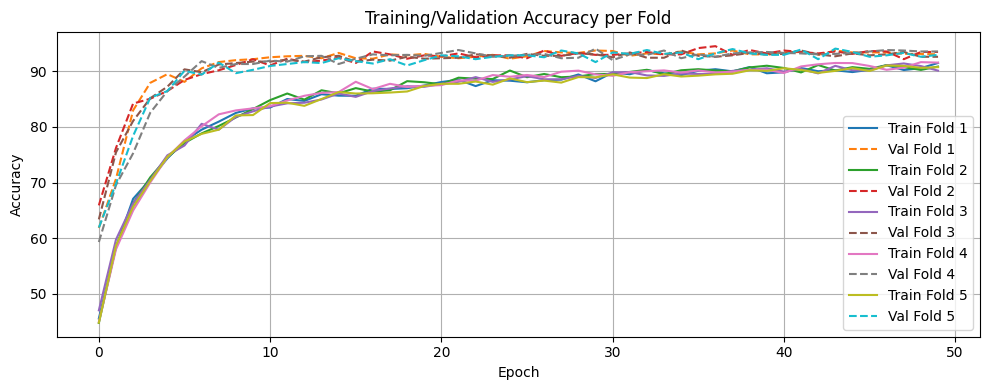

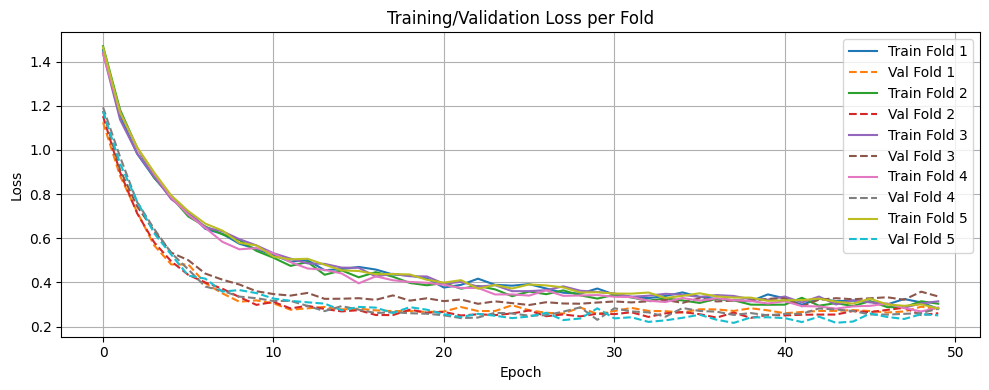

Average validation accuracy across folds: 93.14%


In [10]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))  # Set figure size

# Plot accuracy curves for each fold
for i in range(k_folds):
    plt.plot(fold_train_accuracies[i], label=f'Train Fold {i+1}', linestyle='-')  # Solid line for training accuracy
    plt.plot(fold_val_accuracies[i], label=f'Val Fold {i+1}', linestyle='--')     # Dashed line for validation accuracy

# Configure plot appearance
plt.title('Training/Validation Accuracy per Fold')
plt.xlabel('Epoch')             # X-axis: epoch number
plt.ylabel('Accuracy')          # Y-axis: accuracy percentage
plt.legend()                    # Show legend to distinguish folds
plt.grid(True)                  # Add grid for readability
plt.tight_layout()              # Adjust layout to prevent clipping
plt.show()                      # Display the plot

# Plot Training and Validation Loss
plt.figure(figsize=(10, 4))  # Set figure size

# Plot loss curves for each fold
for i in range(k_folds):
    plt.plot(fold_train_losses[i], label=f'Train Fold {i+1}', linestyle='-')  # Solid line for training loss
    plt.plot(fold_val_losses[i], label=f'Val Fold {i+1}', linestyle='--')     # Dashed line for validation loss

# Configure plot appearance
plt.title('Training/Validation Loss per Fold')
plt.xlabel('Epoch')          # X-axis: epoch number
plt.ylabel('Loss')           # Y-axis: loss value
plt.legend()                 # Show legend to distinguish folds
plt.grid(True)               # Add grid for readability
plt.tight_layout()           # Adjust layout
plt.show()                   # Display the plot

# Calculate and print average validation accuracy across all folds
avg_val_acc = np.mean([accs[-1] for accs in fold_val_accuracies])
print(f"Average validation accuracy across folds: {avg_val_acc:.2f}%")

## Retraining on Full Training Data

Using the best performing fold, we are now training on the full data set. We're using the same parameters as before (50 epochs, Adam optimiser at learning rate 0.001 and weight decay 1e-4, batch size 32).

In [11]:
# Prepare full training dataset and dataloader
full_train_ds = MotionSense(X_train, Y_train)                      # Use entire training set
full_train_dl = DataLoader(full_train_ds, batch_size=32, shuffle=True)  # DataLoader for batching and shuffling

# Initialize the model
model = FCNet(input_size, hidden_size, num_classes)

# Load weights from the best-performing fold 
model.load_state_dict(best_model_state)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Retrain for a fixed number of epochs using the full dataset
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0
    correct = 0
    total = 0

    # Iterate over batches
    for inputs, labels in full_train_dl:
        optimizer.zero_grad()                    # Reset gradients
        outputs = model(inputs.float())          # Forward pass
        loss = criterion(outputs, labels.long()) # Compute loss
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Update model weights

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute epoch-level loss and accuracy
    epoch_loss = running_loss / len(full_train_dl)
    epoch_acc = 100 * correct / total

    # Print training progress
    print(f"Retrain Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")



Retrain Epoch 1: Loss = 0.3533, Accuracy = 89.67%
Retrain Epoch 2: Loss = 0.3219, Accuracy = 90.70%
Retrain Epoch 3: Loss = 0.3306, Accuracy = 90.20%
Retrain Epoch 4: Loss = 0.3392, Accuracy = 89.96%
Retrain Epoch 5: Loss = 0.3207, Accuracy = 90.61%
Retrain Epoch 6: Loss = 0.3422, Accuracy = 89.77%
Retrain Epoch 7: Loss = 0.2962, Accuracy = 90.72%
Retrain Epoch 8: Loss = 0.3148, Accuracy = 91.01%
Retrain Epoch 9: Loss = 0.3274, Accuracy = 90.01%
Retrain Epoch 10: Loss = 0.3028, Accuracy = 90.70%
Retrain Epoch 11: Loss = 0.2979, Accuracy = 90.99%
Retrain Epoch 12: Loss = 0.2872, Accuracy = 91.09%
Retrain Epoch 13: Loss = 0.2913, Accuracy = 91.06%
Retrain Epoch 14: Loss = 0.2964, Accuracy = 90.75%
Retrain Epoch 15: Loss = 0.3229, Accuracy = 90.27%
Retrain Epoch 16: Loss = 0.3058, Accuracy = 90.63%
Retrain Epoch 17: Loss = 0.2988, Accuracy = 90.53%
Retrain Epoch 18: Loss = 0.3049, Accuracy = 91.16%
Retrain Epoch 19: Loss = 0.2918, Accuracy = 90.92%
Retrain Epoch 20: Loss = 0.2914, Accurac

## Testing Time



In [12]:
# Prepare test dataset and DataLoader
test_ds = MotionSense(X_test, Y_test)                  # Create dataset from test features and labels
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)  # DataLoader without shuffling for evaluation

model.eval()   # Set model to evaluation mode (disables dropout, batchnorm updates)
all_preds = [] # To store predicted labels for all test samples
all_labels = [] # To store true labels for all test samples

# Disable gradient computation for faster inference and lower memory usage
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = model(inputs.float())               # Forward pass to get outputs/logits
        _, predicted = torch.max(outputs.data, 1)    # Get class with highest score as prediction
        all_preds.extend(predicted.cpu().numpy())    # Collect predictions on CPU as numpy array
        all_labels.extend(labels.cpu().numpy())      # Collect true labels

# Convert collected lists to numpy arrays for metric calculations
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall test accuracy
test_acc = 100 * (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {test_acc:.2f}%")

# Calculate additional performance metrics with weighted averaging for imbalanced classes
precision = precision_score(all_labels, all_preds, average='weighted')  # Precision metric
recall = recall_score(all_labels, all_preds, average='weighted')        # Recall metric
f1 = f1_score(all_labels, all_preds, average='weighted')                # F1 score metric
conf_matrix = confusion_matrix(all_labels, all_preds)                   # Confusion matrix

# Print the computed metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Print detailed classification report with per-class metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 93.21%
Precision: 0.9339
Recall: 0.9321
F1 Score: 0.9305
Confusion Matrix:
[[111   2  10   1   1   0]
 [  3 136  17   0   3   2]
 [  3   2 308   0   3   0]
 [ 15  12   6  94   2   0]
 [  0   0   0   1 237   0]
 [  0   0   0   0   0 254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       125
           1       0.89      0.84      0.87       161
           2       0.90      0.97      0.94       316
           3       0.98      0.73      0.84       129
           4       0.96      1.00      0.98       238
           5       0.99      1.00      1.00       254

    accuracy                           0.93      1223
   macro avg       0.93      0.91      0.91      1223
weighted avg       0.93      0.93      0.93      1223



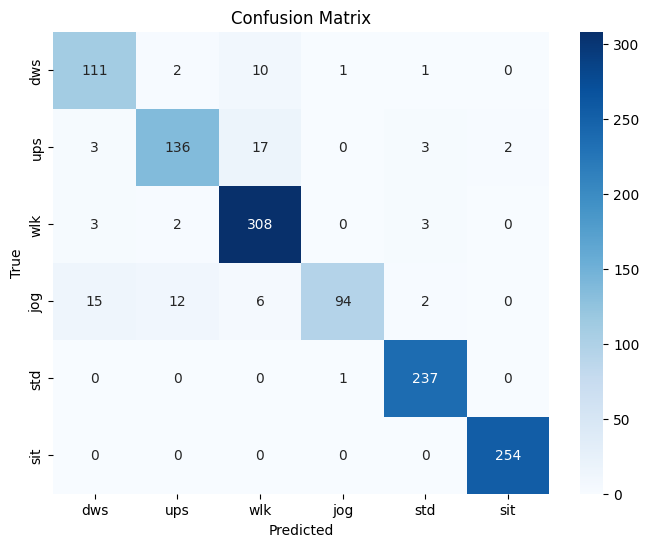

In [13]:
import seaborn as sns

# Set up the plot with a specific size for better readability
plt.figure(figsize=(8,6))

# Create a heatmap visualization of the confusion matrix using Seaborn
sns.heatmap(
    conf_matrix,            # Confusion matrix data to visualize
    annot=True,             # Annotate cells with numeric values
    fmt='d',                # Format annotations as integers
    cmap='Blues',           # Use a blue color palette for the heatmap
    xticklabels=['dws', 'ups', 'wlk', 'jog', 'std', 'sit'],  # Class labels for predicted axis
    yticklabels=['dws', 'ups', 'wlk', 'jog', 'std', 'sit']   # Class labels for true axis
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
